In [1]:
suppressPackageStartupMessages(library(readxl))
suppressPackageStartupMessages(library(data.table))
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(lme4))
#suppressPackageStartupMessages(library(lmerTest))
suppressPackageStartupMessages(library(limma))
suppressPackageStartupMessages(library(tibble))
suppressPackageStartupMessages(library(gridExtra))
suppressPackageStartupMessages(library(ggplot2))

## Differential expression analysis of Olink at Time point 1
### Comparing protein expression between the 3 groups with prediabetic group as control
#### Identify proteins at T1 which are predictive of the outcome 

In [2]:
d = fread('/ictstr01/groups/itg/teams/zeggini/projects/PLIS/proteomics/QC/t1_Olink_QCed.csv')
protein_info = fread('/ictstr01/groups/itg/teams/zeggini/projects/PLIS/proteomics/QC/assay-info.csv')
protein_info = subset(protein_info, select = -c(MissingFreq, Panel, Panel_Lot_Nr, Normalization, ExploreVersion))
d2 <- inner_join(d, protein_info, by = "OlinkID")
head(d2)
# For use later
assay.ids = unique(d2[,.(OlinkID, UniProt, Assay)])

SampleID,OlinkID,LOD,NPX,QC_Warning,Assay_Warning,belowLOD,status,UniProt,Assay
<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<lgl>,<chr>,<chr>,<chr>
Sample_1054,OID20049,-0.3111,-0.4295,PASS,PASS,TRUE,belowLOD,P16860,NPPB
Sample_638,OID20049,-0.3111,3.0496,PASS,PASS,FALSE,ok,P16860,NPPB
Sample_945,OID20049,-0.3111,-0.1432,PASS,PASS,FALSE,ok,P16860,NPPB
Sample_864,OID20049,-0.3111,2.6965,PASS,PASS,FALSE,ok,P16860,NPPB
Sample_531,OID20049,-0.3111,0.4837,PASS,PASS,FALSE,ok,P16860,NPPB
Sample_957,OID20049,-0.3111,2.7744,PASS,PASS,FALSE,ok,P16860,NPPB


In [4]:
options(width=300)
covar = fread('/ictstr01/groups/itg/teams/zeggini/projects/PLIS/proteomics/QC/T1_final_covariates.csv')
covar$SubjectID <- gsub("SubjectID_", "", covar$SubjectID)
covar[,`:=`(
    Gender=as.factor(Gender),
    Site=as.factor(Site))]
#adding case-control information
healthy <- fread("/ictstr01/groups/itg/teams/zeggini/projects/PLIS/proteomics/phenotype-data/3_healthy_pQTLs/subject_ids.txt")
prediabetes <- fread("/ictstr01/groups/itg/teams/zeggini/projects/PLIS/proteomics/phenotype-data/5_prediabetic_pQTLs/subject_ids.txt")
diabetes <- fread("/ictstr01/groups/itg/teams/zeggini/projects/PLIS/proteomics/phenotype-data/4_diabetic_pQTLs/subject_ids.txt")
# healthy <- fread("/ictstr01/groups/itg/teams/zeggini/projects/PLIS/proteomics/differential_expression_analysis/new_definition_analysis/AW_Patient list/remission_clean.txt")
# prediabetes <- fread("/ictstr01/groups/itg/teams/zeggini/projects/PLIS/proteomics/differential_expression_analysis/new_definition_analysis/AW_Patient list/prediabetes_clean.txt")
# diabetes <- fread("/ictstr01/groups/itg/teams/zeggini/projects/PLIS/proteomics/differential_expression_analysis/new_definition_analysis/AW_Patient list/diabetic_clean.txt")

# covar[grepl('FB', SampleID), sample.type:='control']
summary(covar)

   SampleID          SubjectID              Age             Age2      Gender     MeanNPX              Site      storage_time   
 Length:831         Length:831         Min.   :23.00   Min.   : 529   m:357   Min.   :-0.50246   TUE    :285   Min.   : 0.910  
 Class :character   Class :character   1st Qu.:52.50   1st Qu.:2756   w:474   1st Qu.:-0.10905   DRE    :181   1st Qu.: 7.730  
 Mode  :character   Mode  :character   Median :60.00   Median :3600           Median : 0.03903   Charite: 86   Median : 8.530  
                                       Mean   :59.23   Mean   :3606           Mean   : 0.04564   TUM    : 67   Mean   : 8.536  
                                       3rd Qu.:67.00   3rd Qu.:4489           3rd Qu.: 0.17739   UKH    : 66   3rd Qu.: 9.660  
                                       Max.   :80.00   Max.   :6400           Max.   : 1.16411   LEI    : 44   Max.   :11.260  
                                                                                                 (Other)

In [5]:
healthy$status <- rep("healthy", length(healthy$V1))
prediabetes$status <- rep("prediabetes", length(prediabetes$V1))
diabetes$status <- rep("diabetes", length(diabetes$V1))
t2d_status <- rbind(healthy, prediabetes, diabetes)
colnames(t2d_status)[colnames(t2d_status) == "V1"] <- "SubjectID"

In [6]:
covar$SubjectID = as.numeric(covar$SubjectID)
t2d_status$SubjectID = as.numeric(t2d_status$SubjectID)
covar_2 <- inner_join(covar, t2d_status, by = "SubjectID")
head(covar_2)

SampleID,SubjectID,Age,Age2,Gender,MeanNPX,Site,storage_time,status
<chr>,<dbl>,<int>,<int>,<fct>,<dbl>,<fct>,<dbl>,<chr>
Sample_1054,45209,59,3481,w,0.0649311663,DIF,7.44,diabetes
Sample_531,20022,62,3844,m,0.2059205280,DRE,9.99,prediabetes
Sample_154,3751,57,3249,m,0.0006529157,TUE,8.72,healthy
Sample_1063,45233,65,4225,w,0.4563622931,DIF,7.25,prediabetes
Sample_1338,70083,47,2209,w,0.3378155240,LEI,7.41,healthy
Sample_957,40254,67,4489,w,0.0259442868,Charite,8.05,prediabetes


In [7]:
covar_2$status <- factor(covar_2$status, levels = c('prediabetes', 'diabetes', 'healthy'))

In [8]:
# Exclude the 3 bimodal distribution assays
bimodal.assays = assay.ids[Assay %in% c('TDGF1', 'PNLIPRP2', 'FOLR3'), OlinkID]
d3 <- d2[d2$Assay != "TDGF1"]
d3 <- d3[d3$Assay != "PNLIPRP2"]
d3 <- d3[d3$Assay != "FOLR3"]

#### Seperating diabetes and healthy to be compared against prediabetes

#### Healthy vs. Prediabetes

In [9]:
sample_subject_ids = subset(covar_2, select = -c(Age, Age2, Gender, MeanNPX, Site, storage_time))
d3.1 = inner_join(d3, sample_subject_ids, by = "SampleID")
d3.1 = d3.1[!d3.1$status.y == "diabetes"]
d3.1 = subset(d3.1, select = -c(LOD, QC_Warning, Assay_Warning, belowLOD, status.x, status.y, UniProt, Assay, SubjectID))
covar_3 <- covar_2[!covar_2$status == "diabetes"]
covar_3$status <- factor(covar_3$status, levels = c('prediabetes', 'healthy'))
head(d3.1)
head(covar_3)

SampleID,OlinkID,NPX
<chr>,<chr>,<dbl>
Sample_864,OID20049,2.6965
Sample_531,OID20049,0.4837
Sample_957,OID20049,2.7744
Sample_437,OID20049,-0.5352
Sample_154,OID20049,1.0705
Sample_60,OID20049,-1.6001


SampleID,SubjectID,Age,Age2,Gender,MeanNPX,Site,storage_time,status
<chr>,<dbl>,<int>,<int>,<fct>,<dbl>,<fct>,<dbl>,<fct>
Sample_531,20022,62,3844,m,0.2059205280,DRE,9.99,prediabetes
Sample_154,3751,57,3249,m,0.0006529157,TUE,8.72,healthy
Sample_1063,45233,65,4225,w,0.4563622931,DIF,7.25,prediabetes
Sample_1338,70083,47,2209,w,0.3378155240,LEI,7.41,healthy
Sample_957,40254,67,4489,w,0.0259442868,Charite,8.05,prediabetes
Sample_846,30011,60,3600,w,0.0632875887,DDZ,9.71,prediabetes


In [10]:
wide = reshape(d3.1, idvar='SampleID', timevar='OlinkID', direction='wide')
colnames(wide) = sub('NPX.', '', colnames(wide))
wide = as.matrix(wide)
rownames(wide) = wide[,1]
wide = wide[,2:ncol(wide)]
class(wide) = "numeric"
cat('Number of assays included in analysis:', length(unique(d3.1[,OlinkID])), '\n')

Number of assays included in analysis: 2536 


In [11]:
in_prot = wide
in_prot = t(in_prot)

in_pheno = covar_3
in_pheno = as.data.frame(in_pheno)
rownames(in_pheno) = in_pheno[,1]

In [12]:
table(merge(unique(d3.1[,.(SampleID)]), covar_3[,.(SampleID, status)])[,status])


prediabetes     healthy 
        321          49 

In [13]:
keep_samples = intersect(colnames(in_prot), rownames(in_pheno))
curr_prot = in_prot[,keep_samples]
curr_pheno = in_pheno[keep_samples,]

In [14]:
print(paste0("protein matrices and phenotype info in same sample order: ", 
   identical(colnames(curr_prot), rownames(curr_pheno))))
print(paste0("# samples being tested: ", nrow(curr_pheno)))

[1] "protein matrices and phenotype info in same sample order: TRUE"
[1] "# samples being tested: 370"


In [15]:
options(repr.matrix.max.rows = 5)
design = model.matrix(as.formula("~ status + Age + Age2 + Gender + MeanNPX + Site + storage_time"), 
#                                        data = curr_pheno)
#design = model.matrix(as.formula("~ status + Age + Age2 + Gender + Site + storage_time"), 
                                       data = curr_pheno)
design

,(Intercept),statushealthy,Age,Age2,Genderw,MeanNPX,SiteDDZ,SiteDIF,SiteDRE,SiteLEI,SiteLMU,SiteLMU_2,SiteTUE,SiteTUM,SiteUKH,storage_time
Sample_864,1,0,63,3969,1,0.09637979,1,0,0,0,0,0,0,0,0,8.47
Sample_531,1,0,62,3844,0,0.20592053,0,0,1,0,0,0,0,0,0,9.99
Sample_957,1,0,67,4489,1,0.02594429,0,0,0,0,0,0,0,0,0,8.05
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
Sample_1228,1,0,47,2209,1,-0.10972792,0,0,0,0,0,0,0,1,0,8.44
Sample_580,1,0,47,2209,0,-0.09357956,0,0,1,0,0,0,0,0,0,9.69


In [16]:
fit_here = lmFit(curr_prot, design)
# https://stat.ethz.ch/pipermail/bioconductor/2004-September/006132.html
# --> ebayes explanation
bayes = eBayes(fit_here)

Warning message:
“Partial NA coefficients for 1 probe(s)”


In [17]:
ls(fit_here)
ls(bayes)

[1] "Amean"            "coefficients"     "cov.coefficients" "design"           "df.residual"      "method"           "pivot"            "rank"             "sigma"            "stdev.unscaled"

[1] "Amean"            "coefficients"     "cov.coefficients" "design"           "df.prior"         "df.residual"      "df.total"         "F"                "F.p.value"        "lods"             "method"           "p.value"          "pivot"            "proportion"       "rank"            
[16] "s2.post"          "s2.prior"         "sigma"            "stdev.unscaled"   "t"                "var.prior"

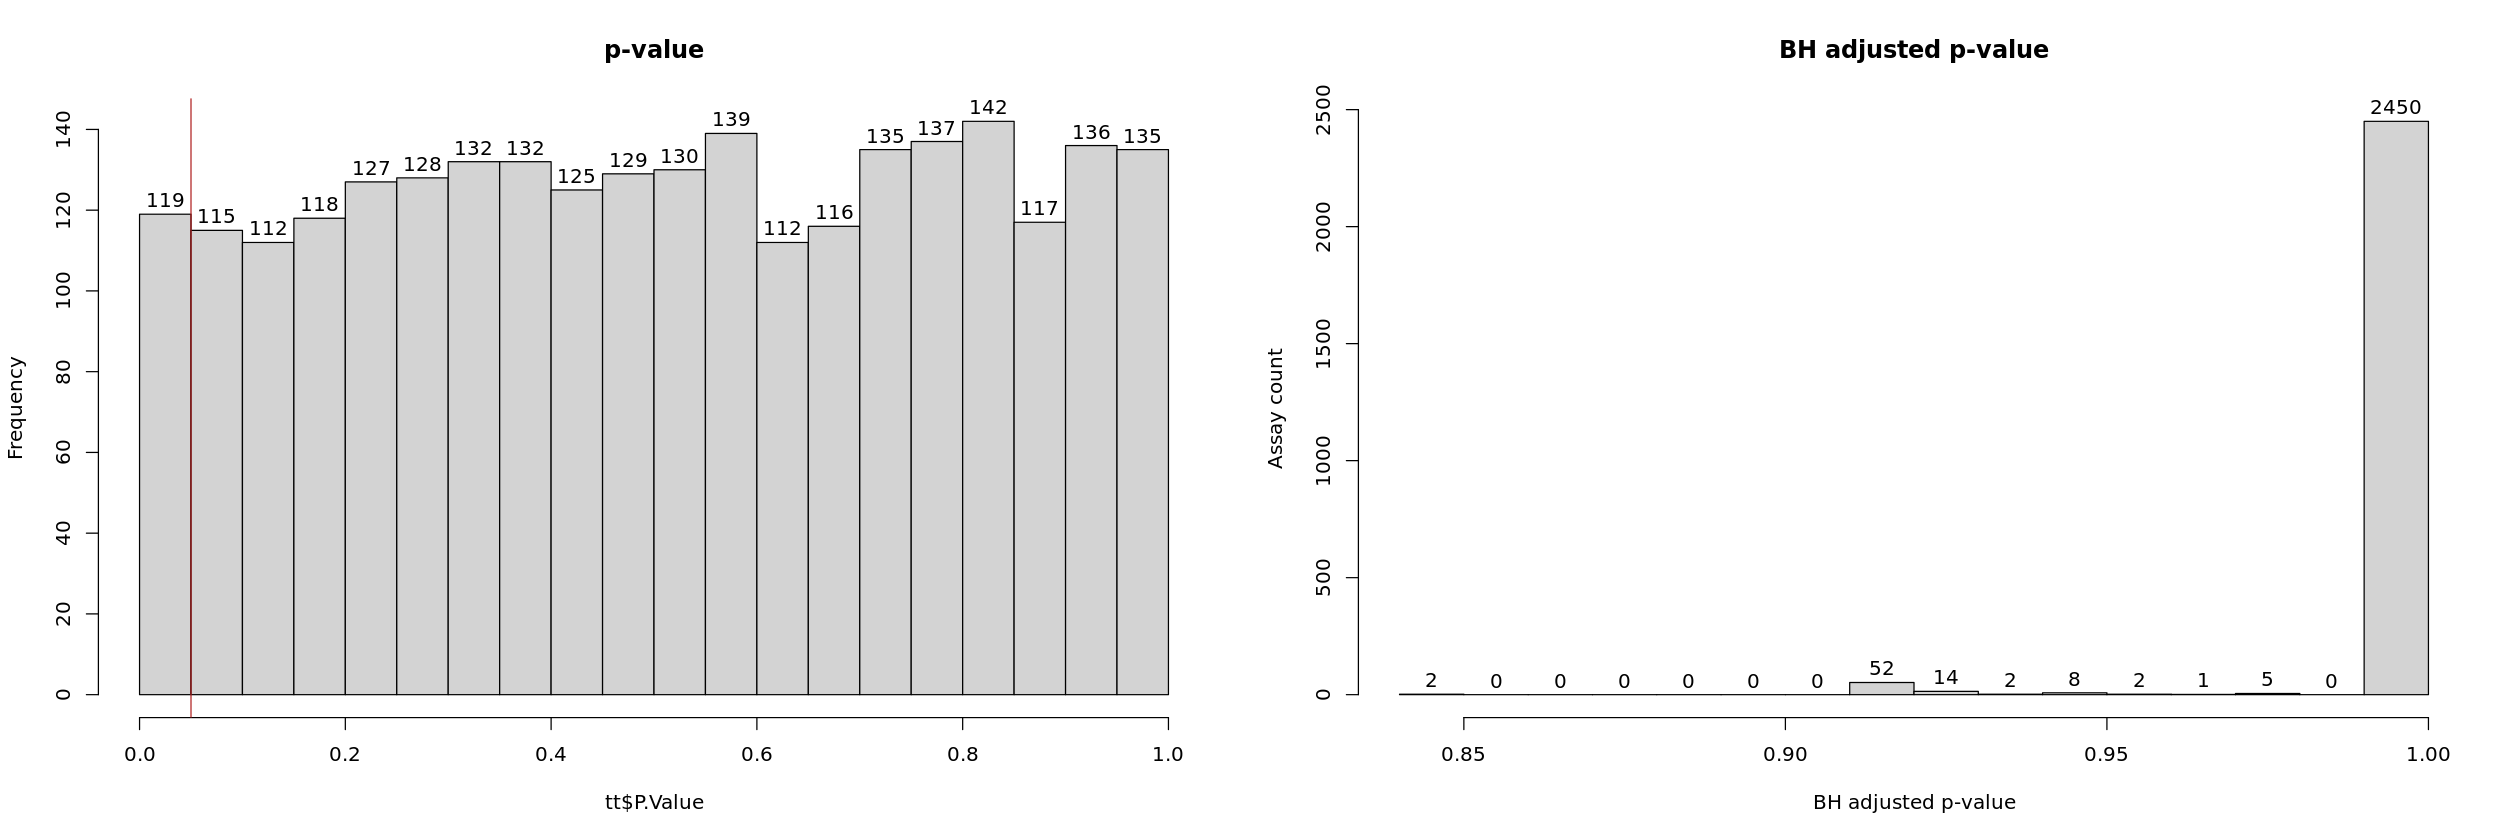

In [18]:
tt = topTable(bayes, coef = "statushealthy", n = Inf, adjust.method="BH")
tt = tt[order(tt$adj.P.Val),]

tt_fdr005 = subset(tt, tt$adj.P.Val < 0.05)


options(repr.plot.width = 21, repr.plot.height = 7)
par(mfrow=c(1,2))
hist(tt$P.Value, breaks = 20, labels = TRUE, main = 'p-value')
abline(v=0.05, col='firebrick')
hist(tt$adj.P.Val, breaks = 20, labels = TRUE, main = 'BH adjusted p-value', xlab='BH adjusted p-value', ylab='Assay count')
abline(v=0.05, col='firebrick')

In [19]:
options(repr.matrix.max.rows = 10)
tt
dim(tt)
cat(paste0(nrow(tt[tt$adj.P.Val<0.05,]), ' out of 2536 assays with FDR<0.05'))

,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
OID20486,0.2469526,-0.018891351,3.504432,0.0005158208,0.8445923,-1.179635
OID30464,0.3253743,0.019499458,3.433496,0.0006660822,0.8445923,-1.335612
OID31074,-0.1502714,0.022327568,-3.237337,0.0013195533,0.9123161,-1.747523
OID20593,-1.1213425,-0.752863784,-3.183744,0.0015816592,0.9123161,-1.856478
OID21520,-0.1201290,0.002243514,-3.109589,0.0020241280,0.9123161,-2.004457
⋮,⋮,⋮,⋮,⋮,⋮,⋮
OID21191,2.977499e-04,0.052447568,0.0029598990,0.9976400,0.9990881,-5.128900
OID30904,-5.919456e-04,0.064361351,-0.0028762839,0.9977067,0.9990881,-5.128900
OID30318,-1.115882e-04,-0.016039189,-0.0023157062,0.9981536,0.9990881,-5.128901


[1] 2536    6

0 out of 2536 assays with FDR<0.05

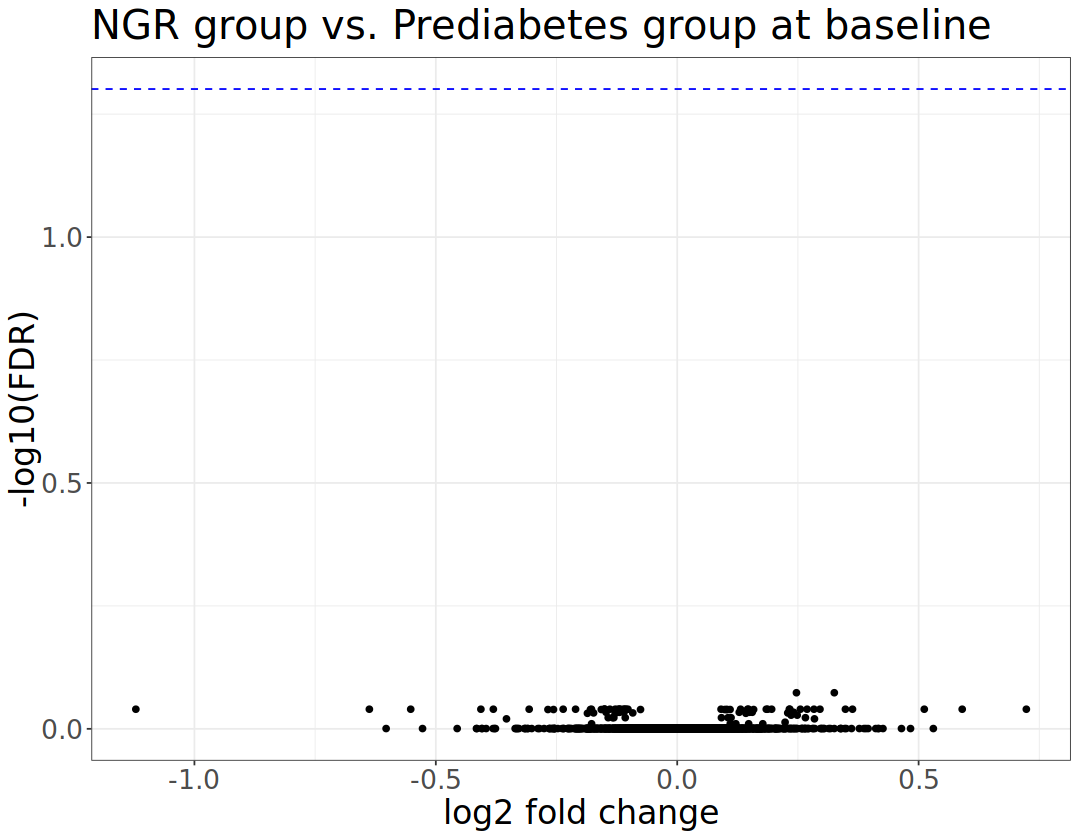

In [21]:
options(repr.plot.width=9, repr.plot.height=7)
sig.threshold = 0.05

tt2 = copy(tt)
tt2$col='grey'
tt2[tt2$adj.P.Val<sig.threshold, 'col'] = 'black'

ggplot(tt2, aes(x = logFC, y = -log10(adj.P.Val), color = col)) +
    geom_point(show.legend=F) +
    geom_hline(yintercept = -log10(sig.threshold), linetype = "dashed", col = "blue") +
    labs(
        x = "log2 fold change",
        y = "-log10(FDR)",
        title = "NGR group vs. Prediabetes group at baseline"
    ) +
    theme_bw() +
    scale_color_manual(values=c("black", "grey")) +
    theme(text = element_text(size=20))
p1 <- ggplot(tt2, aes(x = logFC, y = -log10(adj.P.Val), color = col)) +
    geom_point(show.legend=F) +
    geom_hline(yintercept = -log10(sig.threshold), linetype = "dashed", col = "blue") +
    labs(
        x = "log2 fold change",
        y = "-log10(FDR)",
        title = "A. NGR group vs. Prediabetes group at baseline"
    ) +
    theme_bw() +
    scale_color_manual(values=c("black", "grey")) +
    theme(text = element_text(size=10))

#### Diabetes vs. Prediabetes

In [22]:
sample_subject_ids = subset(covar_2, select = -c(Age, Age2, Gender, MeanNPX, Site, storage_time))
d3.1 = inner_join(d3, sample_subject_ids, by = "SampleID")
d3.1 = d3.1[!d3.1$status.y == "healthy"]
d3.1 = subset(d3.1, select = -c(LOD, QC_Warning, Assay_Warning, belowLOD, status.x, status.y, UniProt, Assay, SubjectID))
covar_3 <- covar_2[!covar_2$status == "healthy"]
covar_3$status <- factor(covar_3$status, levels = c('prediabetes', 'diabetes'))
head(d3.1)
head(covar_3)

SampleID,OlinkID,NPX
<chr>,<chr>,<dbl>
Sample_1054,OID20049,-0.4295
Sample_638,OID20049,3.0496
Sample_864,OID20049,2.6965
Sample_531,OID20049,0.4837
Sample_957,OID20049,2.7744
Sample_437,OID20049,-0.5352


SampleID,SubjectID,Age,Age2,Gender,MeanNPX,Site,storage_time,status
<chr>,<dbl>,<int>,<int>,<fct>,<dbl>,<fct>,<dbl>,<fct>
Sample_1054,45209,59,3481,w,0.06493117,DIF,7.44,diabetes
Sample_531,20022,62,3844,m,0.20592053,DRE,9.99,prediabetes
Sample_1063,45233,65,4225,w,0.45636229,DIF,7.25,prediabetes
Sample_957,40254,67,4489,w,0.02594429,Charite,8.05,prediabetes
Sample_846,30011,60,3600,w,0.06328759,DDZ,9.71,prediabetes
Sample_1320,70047,63,3969,m,-0.06640351,LEI,7.70,diabetes


In [23]:
wide = reshape(d3.1, idvar='SampleID', timevar='OlinkID', direction='wide')
colnames(wide) = sub('NPX.', '', colnames(wide))
wide = as.matrix(wide)
rownames(wide) = wide[,1]
wide = wide[,2:ncol(wide)]
class(wide) = "numeric"
cat('Number of assays included in analysis:', length(unique(d3.1[,OlinkID])), '\n')

Number of assays included in analysis: 2536 


In [24]:
in_prot = wide
in_prot = t(in_prot)

in_pheno = covar_3
in_pheno = as.data.frame(in_pheno)
rownames(in_pheno) = in_pheno[,1]

In [25]:
table(merge(unique(d3.1[,.(SampleID)]), covar_3[,.(SampleID, status)])[,status])


prediabetes    diabetes 
        321          88 

In [26]:
keep_samples = intersect(colnames(in_prot), rownames(in_pheno))
curr_prot = in_prot[,keep_samples]
curr_pheno = in_pheno[keep_samples,]

In [27]:
print(paste0("protein matrices and phenotype info in same sample order: ", 
   identical(colnames(curr_prot), rownames(curr_pheno))))
print(paste0("# samples being tested: ", nrow(curr_pheno)))

[1] "protein matrices and phenotype info in same sample order: TRUE"
[1] "# samples being tested: 409"


In [28]:
options(repr.matrix.max.rows = 5)
design = model.matrix(as.formula("~ status + Age + Age2 + Gender + MeanNPX + Site + storage_time"), 
#                                        data = curr_pheno)
#design = model.matrix(as.formula("~ status + Age + Age2 + Gender + Site + storage_time"), 
                                       data = curr_pheno)
design

,(Intercept),statusdiabetes,Age,Age2,Genderw,MeanNPX,SiteDDZ,SiteDIF,SiteDRE,SiteLEI,SiteLMU,SiteLMU_2,SiteTUE,SiteTUM,SiteUKH,storage_time
Sample_1054,1,1,59,3481,1,0.06493117,0,1,0,0,0,0,0,0,0,7.44
Sample_638,1,1,74,5476,0,0.25251820,0,0,1,0,0,0,0,0,0,8.16
Sample_864,1,0,63,3969,1,0.09637979,1,0,0,0,0,0,0,0,0,8.47
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
Sample_1228,1,0,47,2209,1,-0.10972792,0,0,0,0,0,0,0,1,0,8.44
Sample_580,1,0,47,2209,0,-0.09357956,0,0,1,0,0,0,0,0,0,9.69


In [29]:
fit_here = lmFit(curr_prot, design)
# https://stat.ethz.ch/pipermail/bioconductor/2004-September/006132.html
# --> ebayes explanation
bayes = eBayes(fit_here)

Warning message:
“Partial NA coefficients for 1 probe(s)”


In [30]:
ls(fit_here)
ls(bayes)

[1] "Amean"            "coefficients"     "cov.coefficients" "design"           "df.residual"      "method"           "pivot"            "rank"             "sigma"            "stdev.unscaled"

[1] "Amean"            "coefficients"     "cov.coefficients" "design"           "df.prior"         "df.residual"      "df.total"         "F"                "F.p.value"        "lods"             "method"           "p.value"          "pivot"            "proportion"       "rank"            
[16] "s2.post"          "s2.prior"         "sigma"            "stdev.unscaled"   "t"                "var.prior"

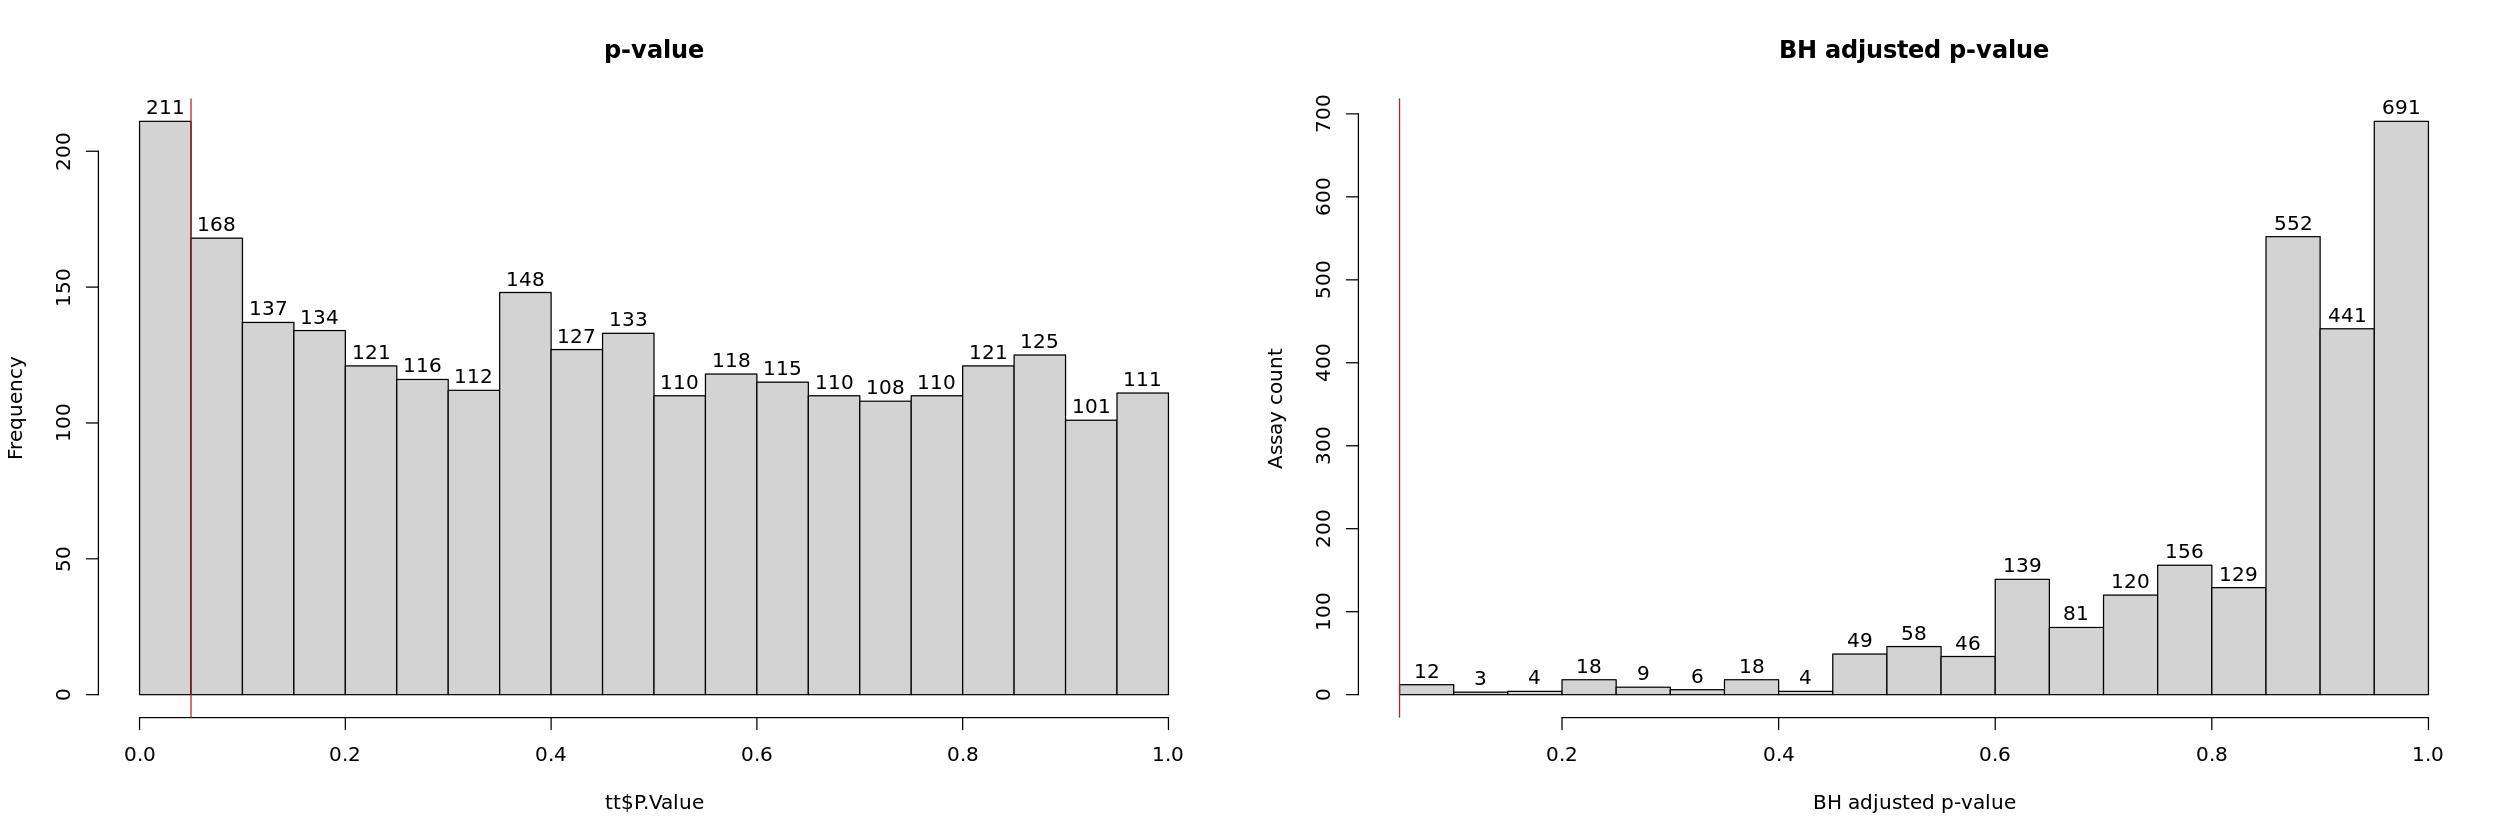

In [31]:
tt = topTable(bayes, coef = "statusdiabetes", n = Inf, adjust.method="BH")
tt = tt[order(tt$adj.P.Val),]

tt_fdr005 = subset(tt, tt$adj.P.Val < 0.05)


options(repr.plot.width = 21, repr.plot.height = 7)
par(mfrow=c(1,2))
hist(tt$P.Value, breaks = 20, labels = TRUE, main = 'p-value')
abline(v=0.05, col='firebrick')
hist(tt$adj.P.Val, breaks = 20, labels = TRUE, main = 'BH adjusted p-value', xlab='BH adjusted p-value', ylab='Assay count')
abline(v=0.05, col='firebrick')

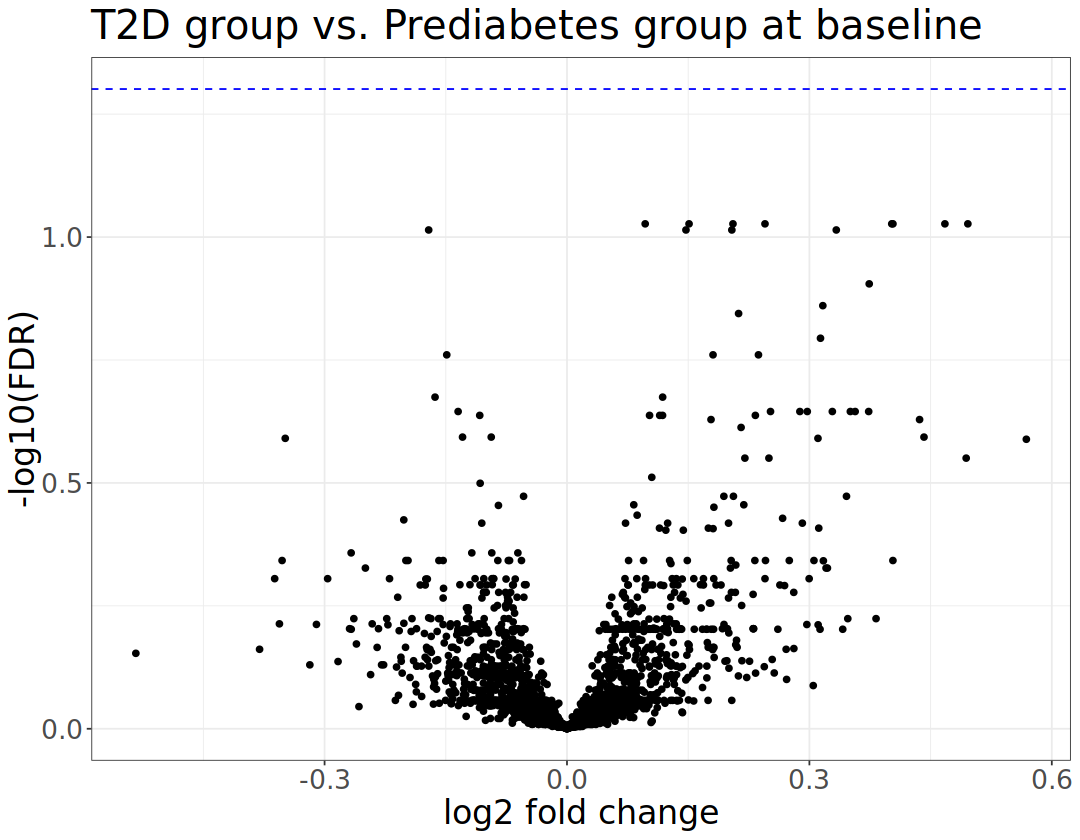

In [ ]:
options(repr.plot.width=9, repr.plot.height=7)
sig.threshold = 0.05

tt2 = copy(tt)
tt2$col='grey'
tt2[tt2$adj.P.Val<sig.threshold, 'col'] = 'black'

ggplot(tt2, aes(x = logFC, y = -log10(adj.P.Val), color = col)) +
    geom_point(show.legend=F) +
    geom_hline(yintercept = -log10(sig.threshold), linetype = "dashed", col = "blue") +
    labs(
        x = "log2 fold change",
        y = "-log10(FDR)",
        title = "T2D group vs. Prediabetes group at baseline"
    ) +
    theme_bw() +
    scale_color_manual(values=c("black", "grey")) +
    theme(text = element_text(size=20))

p2 <- ggplot(tt2, aes(x = logFC, y = -log10(adj.P.Val), color = col)) +
    geom_point(show.legend=F) +
    geom_hline(yintercept = -log10(sig.threshold), linetype = "dashed", col = "blue") +
    labs(
        x = "log2 fold change",
        y = "-log10(FDR)",
        title = "B. T2D group vs. Prediabetes group at baseline"
    ) +
    theme_bw() +
    scale_color_manual(values=c("black", "grey")) +
    theme(text = element_text(size=10))

In [33]:
#Combining the two volcano plots
# Open a PDF device
pdf("/ictstr01/groups/itg/teams/zeggini/projects/PLIS/proteomics/differential_expression_analysis/T1_only/plots/T1_healthy_and_T2D_vs-prediabetes.pdf", width = 10, height = 5)   # adjust width/height as needed

# Draw the plots
grid.arrange(p1, p2, ncol = 2)

# Close the device
dev.off()

pdf 
  2

#### It looks like we don't find a protein signature predictive of intervention outcome from baseline protein levels.